In [20]:
import pandas as pd
import numpy as np

In [21]:
data = pd.read_excel('data.xlsx')

In [22]:
data.head() 

,Q1_性别,Q2_身高（厘米）,Q3_体重 （公斤）,Q4_头发长度（厘米）
0,男,190,70,7
1,女,160,45,20
2,男,179,61,5
3,女,173,60,50
4,男,175,70,15


In [23]:
data = data.rename(columns={'Q1_性别': 'label', 
                            'Q2_身高（厘米）': 'height', 
                            'Q3_体重 （公斤）': 'weight', 
                            'Q4_头发长度（厘米）': 'hair'})

In [24]:
data['label'] = data['label'].apply(lambda x : {'男': 0, '女': 1}[x])

In [25]:
data.head()

,label,height,weight,hair
0,0,190,70,7
1,1,160,45,20
2,0,179,61,5
3,1,173,60,50
4,0,175,70,15


In [26]:
features = data[['height', 'weight', 'hair']].to_numpy()

In [27]:
mean = np.mean(features, axis=0)
std = np.std(features, axis=0)

In [28]:
features = (features - mean)/std  #归一化，正态分布

In [29]:
label = data['label'].to_numpy()

In [30]:
features

array([[ 9.86969285e-01, -2.25614423e-03, -4.63916995e-01],
       [-7.03854590e-01, -8.10707828e-01, -1.44545566e-01],
       [ 3.67000531e-01, -2.93298750e-01, -5.13051061e-01],
       [ 2.88357560e-02, -3.25636818e-01,  5.92465423e-01],
       [ 1.41557348e-01, -2.25614423e-03, -2.67380731e-01],
       [-5.91132998e-01, -5.52003289e-01,  1.01124764e-01],
       [-1.40246631e-01,  3.21124529e-01, -5.13051061e-01],
       [-2.52968223e-01, -4.87327154e-01, -5.13051061e-01],
       [ 1.41557348e-01, -1.63946481e-01, -5.37618094e-01],
       [ 1.41557348e-01, -2.25614423e-03, -5.37618094e-01],
       [-8.16576182e-01, -7.46031693e-01,  5.92465423e-01],
       [ 4.23361327e-01, -6.69322789e-02, -5.62185127e-01],
       [ 4.23361327e-01,  1.59434192e-01, -5.13051061e-01],
       [-7.03854590e-01, -6.81355558e-01, -1.44545566e-01],
       [-3.09329019e-01, -3.25636818e-01, -3.41081830e-01],
       [-7.03854590e-01, -6.81355558e-01,  3.46795093e-01],
       [ 1.41557348e-01, -1.31608414e-01

In [10]:
label

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0])

# Picking a Link Function
Generalized linear models usually tranform a linear model of the predictors by using a [link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function). In logistic regression, the link function is the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). We can implement this really easily.

In [31]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

# Maximizing the Likelihood

To maximize the likelihood, I need a way to compute the likelihood and the gradient of the likelihood. Fortunately, the likelihood (for binary classification) can be reduced to a fairly intuitive form by switching to the log-likelihood. We're able to do this without affecting the weights parameter estimation because log transformation are [monotonic](https://en.wikipedia.org/wiki/Monotonic_function).

For anyone interested in the derivations of the functions I'm using, check out Section 4.4.1 of Hastie, Tibsharani, and Friedman's [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/). For those less mathematically inclined, Carlos Guestrin (Univesity of Washington) details one possible derivation of the log-likelihood in a series of short lectures on [Coursera](https://www.coursera.org/learn/ml-classification/lecture/1ZeTC/very-optional-expressing-the-log-likelihood) using indicator functions.

## Calculating the Log-Likelihood

The log-likelihood can be viewed as as sum over all the training data. Mathematically,
损失函数
$$\begin{equation}
ll = \sum_{i=1}^{N}y_{i}\beta ^{T}x_{i} - log(1+e^{\beta^{T}x_{i}})
\end{equation}$$ 越小越好

where $y$ is the target class, $x_{i}$ represents an individual data point, and $\beta$ is the weights vector.

I can easily turn that into a function and take advantage of matrix algebra.

In [32]:
#分类问题的损失函数
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

## Calculating the Gradient

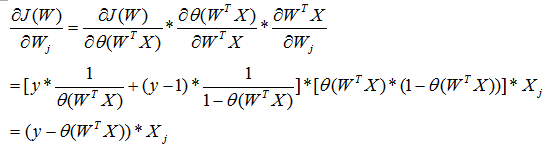

Now I need an equation for the gradient of the log-likelihood. By taking the derivative of the equation above and reformulating in matrix form, the gradient becomes: 

$$\begin{equation}
\bigtriangledown ll = X^{T}(Y - Predictions)
\end{equation}$$

Again, this is really easy to implement. It's so simple I don't even need to wrap it into a function. The gradient here looks very similar to the output layer gradient in a neural network (see my [post](https://beckernick.github.io/neural-network-scratch/) on neural networks if you're curious).

This shouldn't be too surprising, since a neural network is basically just a series of non-linear link functions applied after linear manipulations of the input data.

# Building the Logistic Regression Function

Finally, I'm ready to build the model function. I'll add in the option to calculate the model with an intercept, since it's a good option to have.

权重的迭代公式：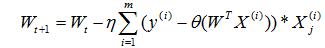


In [33]:
#梯度下降最优化：取误差函数的极小值
def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept: #intercept：有截距b
        intercept = np.ones((features.shape[0], 1)) #features.shape返回(60,3)[0]返回60。生成60行，1列的1
        features = np.hstack((intercept, features)) #在feature前加上一列1  np.vstack():在竖直方向上堆叠；np.hstack():在水平方向上平铺
        
    weights = np.zeros(features.shape[1])  #features.shape[1]返回3，3个权重
    
    for step in range(num_steps):  #迭代多少步
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with log likelihood gradient
        output_error_signal = target - predictions
        
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient

        # Print log-likelihood every so often
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))
        
    return weights

Time to do the regression.

In [34]:
weights = logistic_regression(features, label,
                     num_steps = 50000, learning_rate = 5e-5, add_intercept=True)  #收敛了

-29.794300659677482
-12.17665666438134
-10.368615637493027
-9.699007253564737
-9.355548233950786


In [35]:
print(weights)

[-1.62788588 -3.1418227  -2.31358577  2.1596935 ]


In [36]:
def predict(features, weights):
    global mean
    global std
    features = (features - mean)/std
    intercept = np.ones((features.shape[0], 1))
    features = np.hstack((intercept, features))
    scores = np.dot(features, weights)
    predictions = sigmoid(scores)
    
    return predictions

In [38]:
student1 = np.array([[188, 85, 2]])
print(predict(student1, weights))

[0.00115921]


In [41]:
student2 = np.array([[165, 50, 25]])
print(predict(student2, weights))

[0.76002054]
